In [21]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.api import OLS
from scipy.stats import bootstrap
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


## Poverty

In [22]:
poverty_concat = pd.read_csv('poverty_concat.csv')
poverty_concat.head()

,State,TotalPop,PovertyTotal,PovertyPercent,Year
0,Alabama,4751,796,16.7,2013
1,Alaska,696,76,10.9,2013
2,Arizona,6645,1345,20.2,2013
3,Arkansas,2940,504,17.1,2013
4,California,38050,5675,14.9,2013


## Income 1984-2018

In [23]:
income_df = pd.read_csv('income_df.csv')
income_df.head()

,State,2018,2017,2016,2015,2014,2013,2013.1,2012,2011,...,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984
0,Alabama,49936.0,51113.0,47221.0,44509.0,42278.0,47320.0,41381.0,43464.0,42590.0,...,25082.0,25808.0,24346.0,23357.0,21284.0,19948.0,19734.0,19132.0,18333.0,17310.0
1,Alaska,68734.0,72231.0,75723.0,75112.0,67629.0,72472.0,61137.0,63648.0,57431.0,...,42931.0,41802.0,40612.0,39298.0,36006.0,33103.0,33233.0,31356.0,34782.0,32356.0
2,Arizona,62283.0,61125.0,57100.0,52248.0,49254.0,52611.0,50602.0,47044.0,48621.0,...,30510.0,29358.0,30737.0,29224.0,28552.0,26435.0,26749.0,25500.0,23877.0,21425.0
3,Arkansas,49781.0,48829.0,45907.0,42798.0,44922.0,39376.0,39919.0,39018.0,41302.0,...,23039.0,23882.0,23435.0,22786.0,21433.0,20172.0,18827.0,18730.0,17451.0,15674.0
4,California,70489.0,69759.0,66637.0,63636.0,60487.0,60794.0,57528.0,57020.0,53367.0,...,34073.0,34903.0,33664.0,33290.0,33009.0,30287.0,30146.0,29010.0,26981.0,25287.0


In [24]:
income_melt = pd.read_csv('income_melt_df.csv')
income_melt.head()

,State,Year,Median_Income
0,Alabama,2018,49936.0
1,Alaska,2018,68734.0
2,Arizona,2018,62283.0
3,Arkansas,2018,49781.0
4,California,2018,70489.0


# Unemployment

In [25]:
job_df = pd.read_csv('job_df.csv')
job_melt = pd.read_csv('job_melt.csv')

## Crime 1979-2022

In [26]:
crime_df = pd.read_csv('crime_df.csv')
crime_df

,Year,State_Abbreviation,State,Population,Violent_Crime,Homicide,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary
0,1979,AK,Alaska,406000,1994,54,292,445,1203,23193,5616
1,1979,AL,Alabama,3769000,15578,496,1037,4127,9918,144372,48517
2,1979,AR,Arkansas,2180000,7984,198,595,1626,5565,70949,21457
3,1979,AZ,Arizona,2450000,14528,219,1120,4305,8884,177977,48916
4,1979,CA,California,22696000,184087,2952,12239,75767,93129,1511021,496310
...,...,...,...,...,...,...,...,...,...,...,...
2239,2022,VA,Virginia,8683619,20624,641,2791,3360,13832,148845,10944
2240,2022,WA,Washington,7785786,29504,400,3208,6766,19130,262437,43987
2241,2022,WV,West Virginia,1775156,5213,95,909,210,3999,23663,3561
2242,2022,WI,Wisconsin,5892539,17889,322,2452,2350,12765,80703,9137


# Hypothesis 1:
### Income is a better predictor for robbery than burglary across the states

### Train model for predicting robbery using income

In [27]:
income_robbery = duckdb.sql('''SELECT  Robbery,C.State, C.Year, Median_Income
                            FROM crime_df AS C JOIN income_melt AS I
                            ON C.State = I.State AND C.Year = I.Year
                            ORDER BY C.Year ASC''').df()
income_robbery = pd.get_dummies(income_robbery,prefix='', \
                                prefix_sep='', columns=['State'], dtype=int, drop_first=True)
income_robbery.head()

,Robbery,Year,Median_Income,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,547,1984,32356.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3833,1984,17310.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1587,1984,15674.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4003,1984,21425.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,83924,1984,25287.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X_inc_rob_train, X_inc_rob_test, y_inc_rob_train, y_inc_rob_test = \
                  train_test_split(income_robbery.iloc[:,1:],
                                   income_robbery['Robbery'], test_size=0.3, shuffle=False)
X_inc_rob_train = sm.add_constant(X_inc_rob_train)
inc_rob_model =sm.OLS(y_inc_rob_train, X_inc_rob_train).fit()
#inc_rob_model.summary()

In [29]:
#make predictions
X_inc_rob_test = sm.add_constant(X_inc_rob_test)
inc_rob_preds = inc_rob_model.predict(X_inc_rob_test)
print( f"MAE for predicting robbery using income: {mean_absolute_error(y_inc_rob_test, inc_rob_preds)}")
print( f"RSME for predicting robbery using income: {root_mean_squared_error(y_inc_rob_test, inc_rob_preds)}")

MAE for predicting robbery using income: 3903.309439874085
RSME for predicting robbery using income: 7759.480589023579


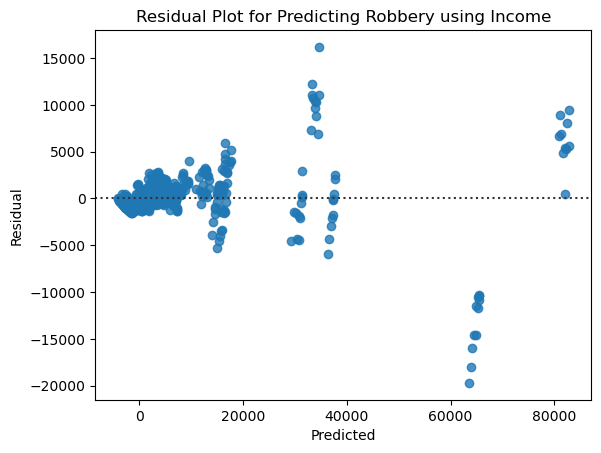

In [30]:

inc_rob_df = pd.DataFrame({"Preds": inc_rob_preds, "Actual": y_inc_rob_test})
ax = sns.residplot(x = inc_rob_preds, y = y_inc_rob_test)
ax.set(xlabel = "Predicted", ylabel= "Residual", title = "Residual Plot for Predicting Robbery using Income");

In [31]:
# for each of the states, get the predicted value and the actual value
X_inc_rob_test2 = X_inc_rob_test
X_inc_rob_test2['actual_robbery'] = y_inc_rob_test
X_inc_rob_test2['preds_robbery'] = inc_rob_preds
inc_rob_melt = pd.melt(X_inc_rob_test2, id_vars=['const','Year', 'Median_Income', 'actual_robbery','preds_robbery'], \
                       var_name = 'State', value_name='Binary')
inc_rob_melt = inc_rob_melt[ inc_rob_melt['Binary']==1]
inc_rob_melt.head()

,const,Year,Median_Income,actual_robbery,preds_robbery,State,Binary
40,1.0,2010,57848.0,594,-1020.717185,Alaska,1
90,1.0,2011,57431.0,576,-1031.663756,Alaska,1
140,1.0,2012,63648.0,630,-1636.744371,Alaska,1
190,1.0,2013,61137.0,623,-1460.154511,Alaska,1
229,1.0,2013,72472.0,623,-2475.305156,Alaska,1


In [32]:
twenty_states = pd.DataFrame(np.random.choice(inc_rob_melt['State'], size =20, replace = False))
#print(twenty_states)
chosen_stats_robbery = duckdb.sql(''' SELECT * FROM inc_rob_melt
                                  WHERE Year>=2014 AND Year<=2018 AND State IN (SELECT * FROM twenty_states)''').df()
chosen_stats_robbery.head()

,const,Year,Median_Income,actual_robbery,preds_robbery,State,Binary
0,1.0,2014,67629.0,629,-2089.863836,Alaska,1
1,1.0,2015,75112.0,761,-2808.326075,Alaska,1
2,1.0,2016,75723.0,850,-2911.339242,Alaska,1
3,1.0,2017,72231.0,952,-2646.892057,Alaska,1
4,1.0,2018,68734.0,896,-2381.997078,Alaska,1


# Income and Robbery for 2016

In [33]:
robbery_2016= chosen_stats_robbery[chosen_stats_robbery['Year']==2016]
robbery_2016_actual = robbery_2016.drop(columns=['const','Binary','preds_robbery'])
robbery_2016_actual['Type'] = 'Actual'
robbery_2016_actual = robbery_2016_actual.rename(columns = {'actual_robbery':'robbery'})

robbery_2016_preds = robbery_2016.loc[:,['Year','Median_Income', 'preds_robbery','State']]
robbery_2016_preds = robbery_2016_preds.rename(columns = {'preds_robbery':'robbery'})
robbery_2016_preds['Type'] = 'Predicted'
print(robbery_2016_actual.head())
robbery_2016_preds.head()

    Year  Median_Income  robbery     State    Type
2   2016        75723.0      850    Alaska  Actual
7   2016        58046.0     1359  Delaware  Actual
12  2016        61386.0    17829  Illinois  Actual
17  2016        56094.0     7291   Indiana  Actual
22  2016        59094.0     1150      Iowa  Actual


,Year,Median_Income,robbery,State,Type
2,2016,75723.0,-2911.339242,Alaska,Predicted
7,2016,58046.0,-1247.222881,Delaware,Predicted
12,2016,61386.0,30169.221445,Illinois,Predicted
17,2016,56094.0,3591.115997,Indiana,Predicted
22,2016,59094.0,-1934.231786,Iowa,Predicted


In [34]:
robbery_2016_preds_actual = pd.concat([robbery_2016_actual , robbery_2016_preds], ignore_index=True, axis=0)
#robbery_2016_preds_actual

[Text(0.5, 1.0, 'Income and Robbery for 20 Random States (2016)')]

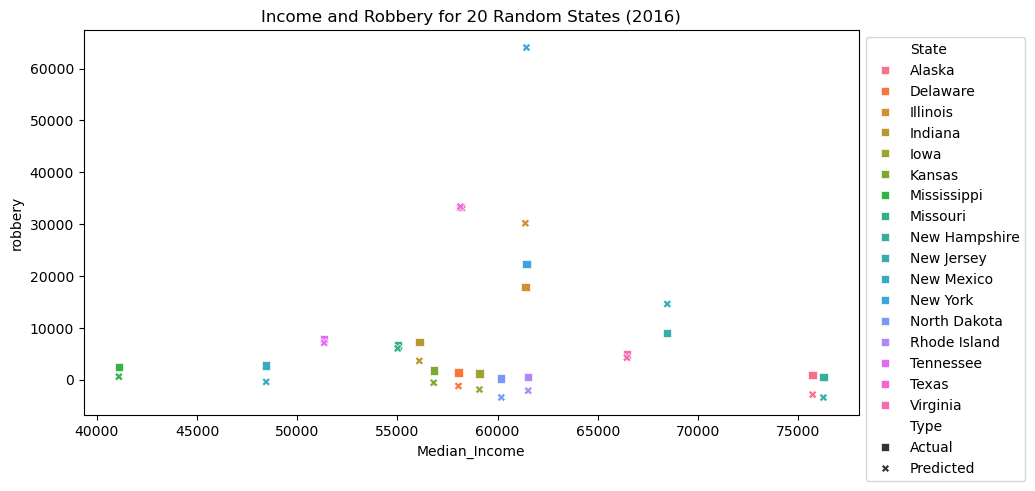

In [35]:
markers = {"Predicted":'X', 'Actual':'s'}
g = sns.scatterplot(data = robbery_2016_preds_actual, x='Median_Income',y='robbery',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Robbery for 20 Random States (2016)")

# Income and Robbery for 2017

In [36]:
robbery_2017= chosen_stats_robbery[chosen_stats_robbery['Year']==2017]
robbery_2017_actual = robbery_2017.drop(columns=['const','Binary','preds_robbery'])
robbery_2017_actual['Type'] = 'Actual'
robbery_2017_actual = robbery_2017_actual.rename(columns = {'actual_robbery':'robbery'})

robbery_2017_preds = robbery_2017.loc[:,['Year','Median_Income', 'preds_robbery','State']]
robbery_2017_preds = robbery_2017_preds.rename(columns = {'preds_robbery':'robbery'})
robbery_2017_preds['Type'] = 'Predicted'
robbery_2017_preds_actual = pd.concat([robbery_2017_actual , robbery_2017_preds], ignore_index=True, axis=0)
#print(robbery_2017_actual.head())
#robbery_2017_preds.head()

[Text(0.5, 1.0, 'Income and Robbery for 20 Random States (2017)')]

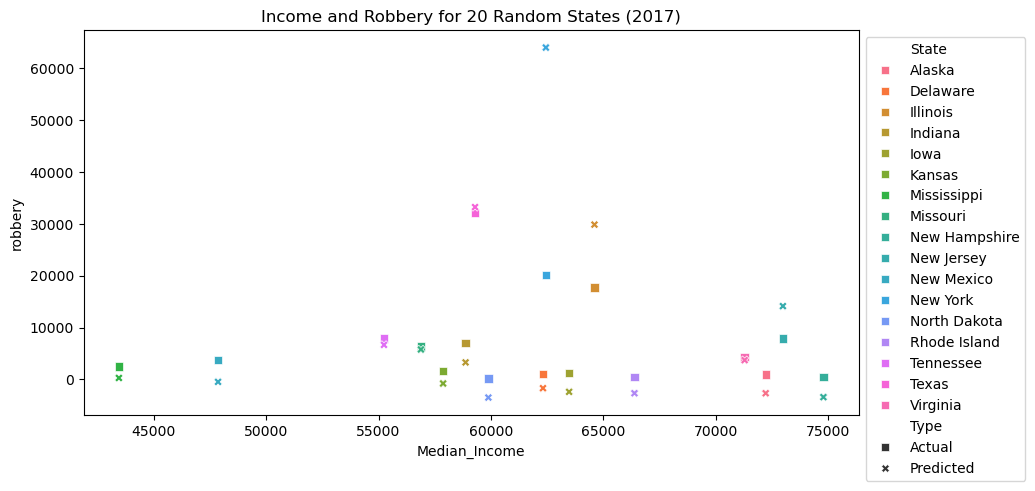

In [37]:
markers = {"Predicted":'X', 'Actual':'s'}
g = sns.scatterplot(data = robbery_2017_preds_actual, x='Median_Income',y='robbery',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Robbery for 20 Random States (2017)")

# Income and Robbery for 2018

In [38]:
robbery_2018= chosen_stats_robbery[chosen_stats_robbery['Year']==2018]
robbery_2018_actual = robbery_2018.drop(columns=['const','Binary','preds_robbery'])
robbery_2018_actual['Type'] = 'Actual'
robbery_2018_actual = robbery_2018_actual.rename(columns = {'actual_robbery':'robbery'})

robbery_2018_preds = robbery_2018.loc[:,['Year','Median_Income', 'preds_robbery','State']]
robbery_2018_preds = robbery_2018_preds.rename(columns = {'preds_robbery':'robbery'})
robbery_2018_preds['Type'] = 'Predicted'
robbery_2018_preds_actual = pd.concat([robbery_2018_actual , robbery_2018_preds], ignore_index=True, axis=0)

[Text(0.5, 1.0, 'Income and Robbery for 20 Random States (2018)')]

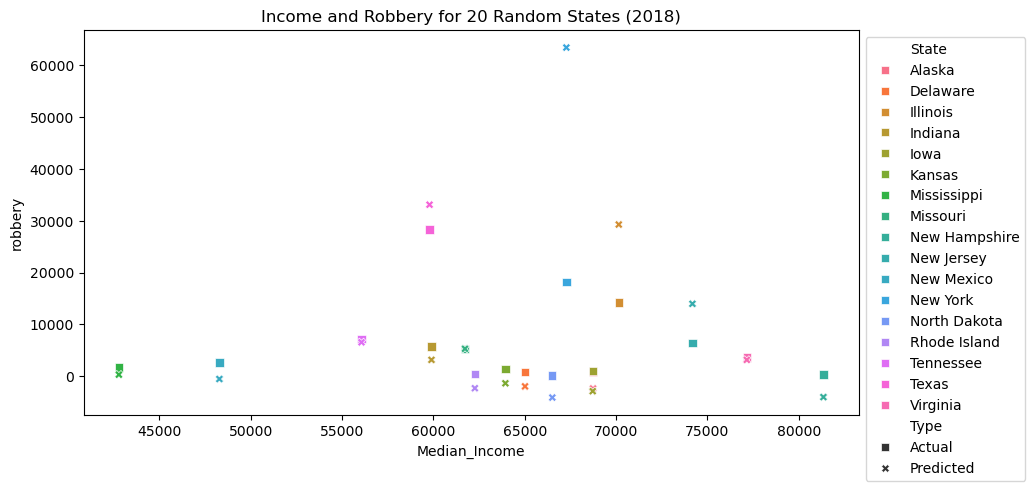

In [39]:
markers = {"Predicted":'X', 'Actual':'s'}
g = sns.scatterplot(data = robbery_2018_preds_actual, x='Median_Income',y='robbery',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Robbery for 20 Random States (2018)")

### Now train model for predicting burglary given income

In [40]:
income_burglary = duckdb.sql('''SELECT  Burglary,C.State, C.Year, Median_Income
                            FROM crime_df AS C JOIN income_melt AS I
                            ON C.State = I.State AND C.Year = I.Year
                            ORDER BY C.Year ASC''').df()
income_burglary = pd.get_dummies(income_burglary,prefix='', \
                                prefix_sep='', columns=['State'], dtype=int, drop_first=True)
income_burglary.head()

,Burglary,Year,Median_Income,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,6184,1984,32356.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39970,1984,17310.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20810,1984,15674.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,52327,1984,21425.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,443094,1984,25287.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X_inc_burg_train, X_inc_burg_test, y_inc_burg_train, y_inc_burg_test = \
                  train_test_split(income_burglary.iloc[:,1:],
                                   income_burglary['Burglary'], test_size=0.3, shuffle=False)
X_inc_burg_train = sm.add_constant(X_inc_burg_train)
inc_burg_model =sm.OLS(y_inc_burg_train, X_inc_burg_train).fit()
#inc_rob_model.summary()

In [42]:
X_inc_burg_test = sm.add_constant(X_inc_burg_test)
inc_burg_preds = inc_burg_model.predict(X_inc_burg_test)
print( f"MAE for predicting burglary using income: {mean_absolute_error(y_inc_burg_test, inc_burg_preds)}")
print( f"RSME for predicting burglary using income: {root_mean_squared_error(y_inc_burg_test, inc_burg_preds)}")

MAE for predicting burglary using income: 17550.16573009597
RSME for predicting burglary using income: 25884.34927546452


[Text(0.5, 0, 'Predicted Burglary'), Text(0, 0.5, 'Residual')]

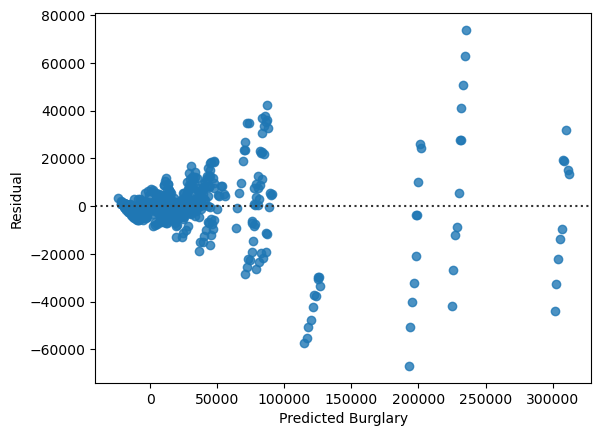

In [43]:
inc_burg_df = pd.DataFrame({"Preds": inc_burg_preds, "Actual": y_inc_burg_test})
ax = sns.residplot(x = inc_burg_preds, y = y_inc_burg_test)
ax.set(xlabel = "Predicted Burglary", ylabel= "Residual")

# Now plot predicted vs actual when using income to predict burglary

In [44]:
X_inc_burg_test2 = X_inc_burg_test
X_inc_burg_test2['actual_burglary'] = y_inc_burg_test
X_inc_burg_test2['preds_burglary'] = inc_burg_preds
inc_burg_melt = pd.melt(X_inc_burg_test2, id_vars=['const','Year', 'Median_Income', 'actual_burglary','preds_burglary'], \
                       var_name = 'State', value_name='Binary')
inc_burg_melt = inc_burg_melt[ inc_burg_melt['Binary']==1]
inc_burg_melt.head()

,const,Year,Median_Income,actual_burglary,preds_burglary,State,Binary
40,1.0,2010,57848.0,3105,-8859.821045,Alaska,1
90,1.0,2011,57431.0,2852,-9539.190170,Alaska,1
140,1.0,2012,63648.0,2950,-11967.147964,Alaska,1
190,1.0,2013,61137.0,2917,-12094.580900,Alaska,1
229,1.0,2013,72472.0,2917,-15082.258405,Alaska,1


In [45]:
chosen_stats_burglary = duckdb.sql(''' SELECT * FROM inc_burg_melt
                                  WHERE Year>=2014 AND Year<=2018 AND State IN (SELECT * FROM twenty_states)''').df()
chosen_stats_burglary.head()

,const,Year,Median_Income,actual_burglary,preds_burglary,State,Binary
0,1.0,2014,67629.0,3150,-14595.023151,Alaska,1
1,1.0,2015,75112.0,3511,-17356.673024,Alaska,1
2,1.0,2016,75723.0,4053,-18307.002227,Alaska,1
3,1.0,2017,72231.0,4167,-18175.863339,Alaska,1
4,1.0,2018,68734.0,3985,-18043.406552,Alaska,1


# Income and Burglary for 2016

In [46]:
burglary_2016= chosen_stats_burglary[chosen_stats_burglary['Year']==2016]
burglary_2016_actual = burglary_2016.drop(columns=['const','Binary','preds_burglary'])
burglary_2016_actual['Type'] = 'Actual'
burglary_2016_actual = burglary_2016_actual.rename(columns = {'actual_burglary':'burglary'})

burglary_2016_preds = burglary_2016.loc[:,['Year','Median_Income', 'preds_burglary','State']]
burglary_2016_preds = burglary_2016_preds.rename(columns = {'preds_burglary':'burglary'})
burglary_2016_preds['Type'] = 'Predicted'
burglary_2016_preds_actual = pd.concat([burglary_2016_actual , burglary_2016_preds], ignore_index=True, axis=0)
#burglary_2016_preds_actual

[Text(0.5, 1.0, 'Income and Burglary for 20 Random States (2016)')]

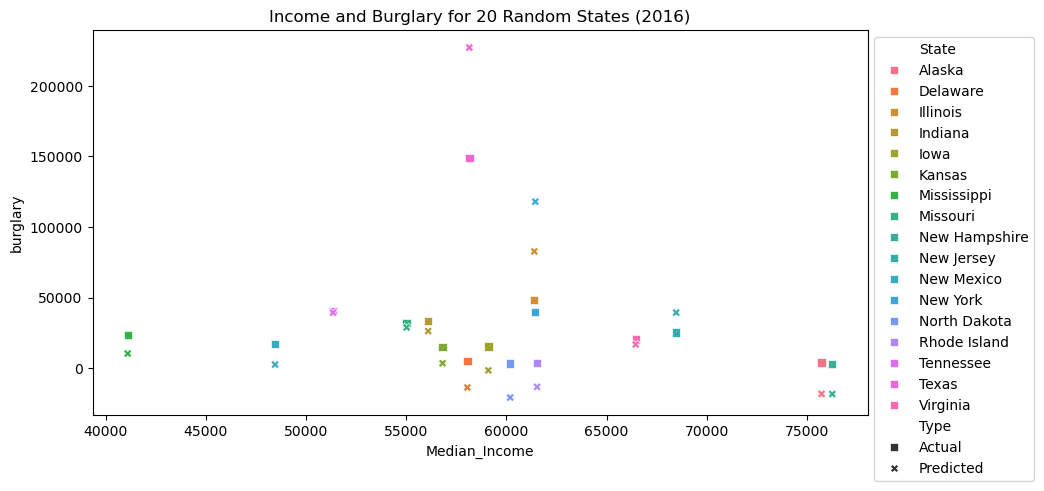

In [47]:
g = sns.scatterplot(data = burglary_2016_preds_actual, x='Median_Income',y='burglary',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Burglary for 20 Random States (2016)")

# Income and Burglary for 2017

In [48]:
burglary_2017= chosen_stats_burglary[chosen_stats_burglary['Year']==2017]
burglary_2017_actual = burglary_2017.drop(columns=['const','Binary','preds_burglary'])
burglary_2017_actual['Type'] = 'Actual'
burglary_2017_actual = burglary_2017_actual.rename(columns = {'actual_burglary':'burglary'})

burglary_2017_preds = burglary_2017.loc[:,['Year','Median_Income', 'preds_burglary','State']]
burglary_2017_preds = burglary_2017_preds.rename(columns = {'preds_burglary':'burglary'})
burglary_2017_preds['Type'] = 'Predicted'
burglary_2017_preds_actual = pd.concat([burglary_2017_actual , burglary_2017_preds], ignore_index=True, axis=0)
#burglary_2017_preds_actual

[Text(0.5, 1.0, 'Income and Burglary for 20 Random States (2017)')]

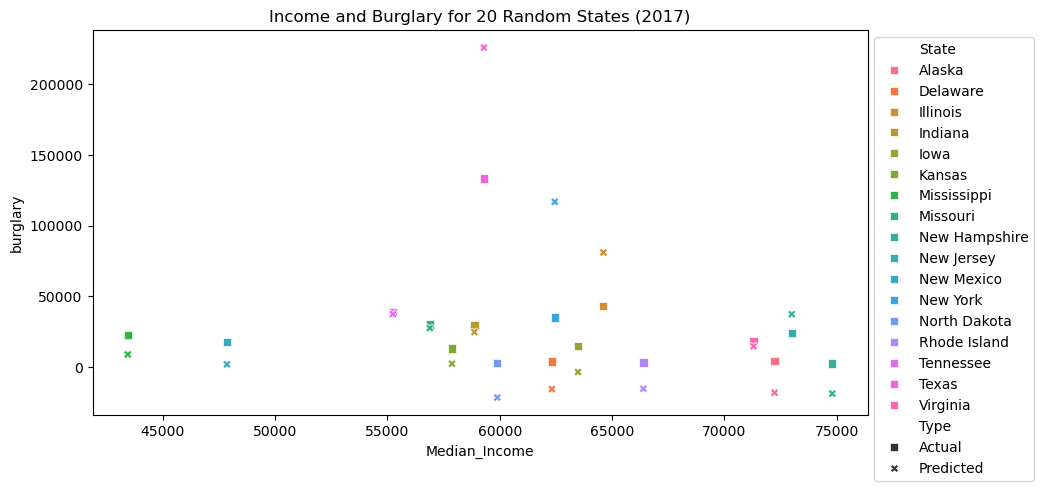

In [49]:
g = sns.scatterplot(data = burglary_2017_preds_actual, x='Median_Income',y='burglary',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Burglary for 20 Random States (2017)")

# Income and Burglary for 2018

In [50]:
burglary_2018= chosen_stats_burglary[chosen_stats_burglary['Year']==2018]
burglary_2018_actual = burglary_2018.drop(columns=['const','Binary','preds_burglary'])
burglary_2018_actual['Type'] = 'Actual'
burglary_2018_actual = burglary_2018_actual.rename(columns = {'actual_burglary':'burglary'})

burglary_2018_preds = burglary_2018.loc[:,['Year','Median_Income', 'preds_burglary','State']]
burglary_2018_preds = burglary_2018_preds.rename(columns = {'preds_burglary':'burglary'})
burglary_2018_preds['Type'] = 'Predicted'
burglary_2018_preds_actual = pd.concat([burglary_2018_actual , burglary_2018_preds], ignore_index=True, axis=0)
#burglary_2018_preds_actual

[Text(0.5, 1.0, 'Income and Burglary for 20 Random States (2018)')]

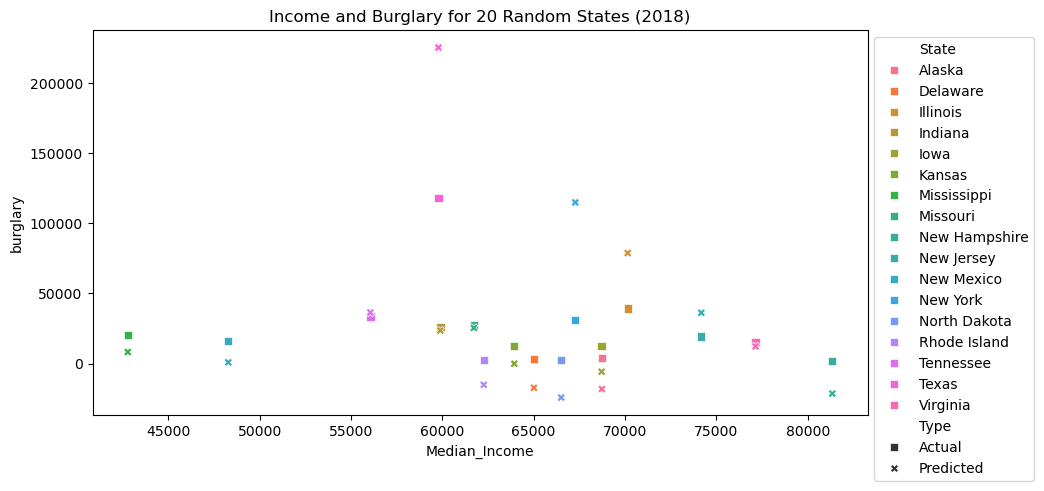

In [51]:
g = sns.scatterplot(data = burglary_2018_preds_actual, x='Median_Income',y='burglary',\
                hue='State', style = 'Type', markers = markers)
g.figure.set_size_inches(10,5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set(title = "Income and Burglary for 20 Random States (2018)")

# Hypothesis 2

### States that are below the U.S unemployment average over the years 1980 to 2018 are more accurate in predicting violent crime than those below the national average

In [52]:
#avg unemployment in the US
us_avg = job_df.iloc[0, 1:]
#print(us_avg)
us_average = us_avg.sum()/us_avg.size
print(us_average)

6.264102564102564


In [53]:
#created a dictionary with all states and their respective unemployment averages across the years 1980 to 2018
dict_avg = {}
states = job_df.iloc[1:, 0].reset_index(drop=True) #rows 0,1,...50
#print(states)

#for x in range(1, 38):
for x in range(0,states.size):
    the_avg = job_df.iloc[x+1, 1:] #get the row for this state
    dict_avg[states[x]] = the_avg.sum()/(2018-1980) + 1

print(dict_avg)


{'Alabama': 8.339473684210525, 'Alaska': 8.976315789473684, 'Arizona': 7.371052631578947, 'Arkansas': 7.628947368421051, 'California': 8.39736842105263, 'Colorado': 6.46578947368421, 'Connecticut': 6.518421052631578, 'Delaware': 6.278947368421052, 'District of Columbia': 8.736842105263161, 'Florida': 7.197368421052631, 'Georgia': 7.1236842105263145, 'Hawaii': 5.7026315789473685, 'Idaho': 7.094736842105262, 'Illinois': 8.157894736842106, 'Indiana': 7.342105263157896, 'Iowa': 5.755263157894736, 'Kansas': 5.88157894736842, 'Kentucky': 8.06578947368421, 'Louisiana': 8.507894736842106, 'Maine': 6.776315789473684, 'Maryland': 6.360526315789474, 'Massachusetts': 6.457894736842107, 'Michigan': 9.092105263157896, 'Minnesota': 5.978947368421053, 'Mississippi': 8.807894736842107, 'Missouri': 7.123684210526315, 'Montana': 6.8921052631578945, 'Nebraska': 4.6421052631578945, 'Nevada': 7.75, 'New Hampshire': 5.3578947368421055, 'New Jersey': 7.221052631578949, 'New Mexico': 7.849999999999999, 'New Yo

In [54]:
less_dict = []
more_dict = []
count = 2
dict_avg[states[count]]

for x in dict_avg:
    rate = dict_avg[x]
    if rate < us_average:
        less_dict.append(x)
    else:
        more_dict.append(x)

print(less_dict)
print(more_dict)


['Hawaii', 'Iowa', 'Kansas', 'Minnesota', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Wyoming']
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Tennessee', 'Texas', 'Washington', 'West Virginia', 'Wisconsin']


In [55]:
#now get the info for states that have above average
states_above_df = job_melt[ job_melt['Area'].isin(more_dict)]
states_above_df.head()

,Area,Year,UnemploymentRate
1,Alabama,1980,8.9
2,Alaska,1980,9.6
3,Arizona,1980,6.6
4,Arkansas,1980,7.6
5,California,1980,6.8


In [56]:
states_above_df = duckdb.sql('''Select  C.Violent_Crime, S.*
                             FROM states_above_df AS S JOIN crime_df AS C
                             ON  S.Year = C.Year AND S.Area = C.State''').df()
states_above_df.head()

,Violent_Crime,Area,Year,UnemploymentRate
0,1919,Alaska,1980,9.6
1,17320,Alabama,1980,8.9
2,7656,Arkansas,1980,7.6
3,210290,California,1980,6.8
4,15215,Colorado,1980,5.8


In [57]:
states_above_df = pd.get_dummies(states_above_df, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['Area'])
states_above_df['Year'] = states_above_df['Year'].astype(int)
states_above_df.head()

,Violent_Crime,Year,UnemploymentRate,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,Tennessee,Texas,Washington,West Virginia,Wisconsin
0,1919,1980,9.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17320,1980,8.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7656,1980,7.6,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,210290,1980,6.8,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15215,1980,5.8,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Actually train the model for years 1980-2018; income and violent crime rate for states above average

In [58]:
X_train_above, X_test_above, Y_train_above, Y_test_above = \
  train_test_split(states_above_df.iloc[:, 1:],states_above_df['Violent_Crime'],\
                    test_size=.30, shuffle=False)
X_train_above = sm.add_constant(X_train_above)
model_above = sm.OLS( Y_train_above,X_train_above).fit()
#model.summary()

In [59]:
X_test_above = sm.add_constant(X_test_above)
preds_above = model_above.predict(X_test_above)
y_above_df = pd.DataFrame(data = {"Preds":preds_above, "Actual":Y_test_above})
y_above_df.head()

,Preds,Actual
1064,7026.161604,7866
1065,-281.314908,5048
1066,123445.548808,94087
1067,-693.544532,3348
1068,83410.052612,53556


In [60]:
print( f"MAE for predicting violent crime rate using states above national average: {mean_absolute_error(preds_above,Y_test_above)}")
print( f"RSME for predicting violent crime rate using states above national average: {root_mean_squared_error(preds_above,Y_test_above)}")

MAE for predicting violent crime rate using states above national average: 7915.812378514593
RSME for predicting violent crime rate using states above national average: 15479.31569571315


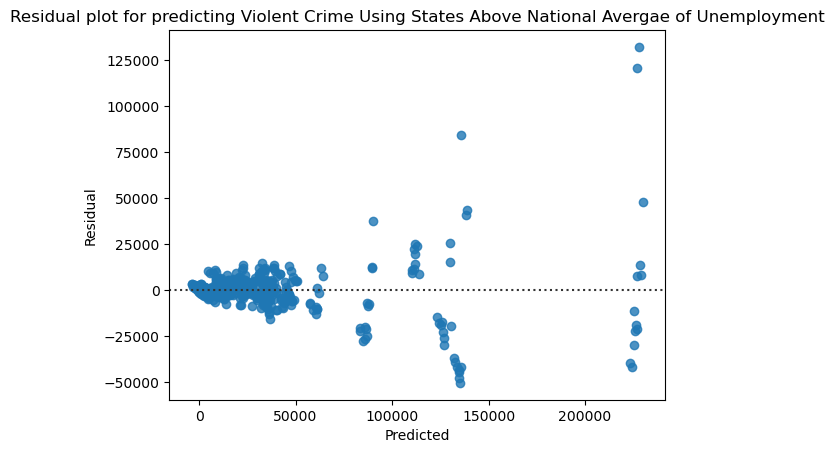

In [61]:
ax = sns.residplot(data= y_above_df, x = 'Preds', y = 'Actual')
ax.set(xlabel = "Predicted", ylabel= "Residual", title="Residual plot for predicting Violent Crime Using States Above National Avergae of Unemployment");

In [62]:
#heatmap for actual values


# Now train model for years 1980-2018; states with unemployment rate below average, violent crime rate

In [63]:
states_below_df = job_melt[ job_melt['Area'].isin(less_dict)]
states_below_df.head()

,Area,Year,UnemploymentRate
12,Hawaii,1980,5.0
16,Iowa,1980,6.0
17,Kansas,1980,4.4
24,Minnesota,1980,5.8
28,Nebraska,1980,3.9


In [64]:
states_below_df = duckdb.sql('''Select  C.Violent_Crime, S.*
                             FROM states_below_df AS S JOIN crime_df AS C
                             ON  S.Year = C.Year AND S.Area = C.State''').df()
states_below_df.head()

,Violent_Crime,Area,Year,UnemploymentRate
0,9168,Kansas,1980,4.4
1,352,North Dakota,1980,4.9
2,3512,Nebraska,1980,3.9
3,4425,Utah,1980,6.2
4,16355,Virginia,1980,5.2


In [65]:
states_below_df = pd.get_dummies(states_below_df, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['Area'])
states_below_df['Year'] = states_below_df['Year'].astype(int)
states_below_df.head()

,Violent_Crime,Year,UnemploymentRate,Iowa,Kansas,Minnesota,Nebraska,New Hampshire,North Dakota,South Dakota,Utah,Vermont,Virginia,Wyoming
0,9168,1980,4.4,0,1,0,0,0,0,0,0,0,0,0
1,352,1980,4.9,0,0,0,0,0,1,0,0,0,0,0
2,3512,1980,3.9,0,0,0,1,0,0,0,0,0,0,0
3,4425,1980,6.2,0,0,0,0,0,0,0,1,0,0,0
4,16355,1980,5.2,0,0,0,0,0,0,0,0,0,1,0


In [66]:
X_train_below, X_test_below, Y_train_below, Y_test_below = \
  train_test_split(states_below_df.iloc[:,1:],
                   states_below_df['Violent_Crime'], test_size=.30, shuffle=False)
#print(Y_test)
X_train_below = sm.add_constant(X_train_below)
model_below = sm.OLS( Y_train_below,X_train_below).fit()
#model.summary()

In [67]:
X_test_below = sm.add_constant(X_test_below)
preds_below = model_below.predict(X_test_below)
y_below_df = pd.DataFrame(data = {"Preds":preds_below, "Actual":Y_test_below})
y_below_df.head()

,Preds,Actual
327,1446.261847,775
328,2184.911415,1212
329,3798.416198,3362
330,8725.378708,8484
331,11175.272298,10235


In [68]:
print( f"MAE for predicting violent crime rate using states below national average: {mean_absolute_error(preds_below,Y_test_below)}")
print( f"RSME for predicting violent crime rate using states below national average: {root_mean_squared_error(preds_below,Y_test_below)}")

MAE for predicting violent crime rate using states below national average: 877.0012541509234
RSME for predicting violent crime rate using states below national average: 1236.8501710792377


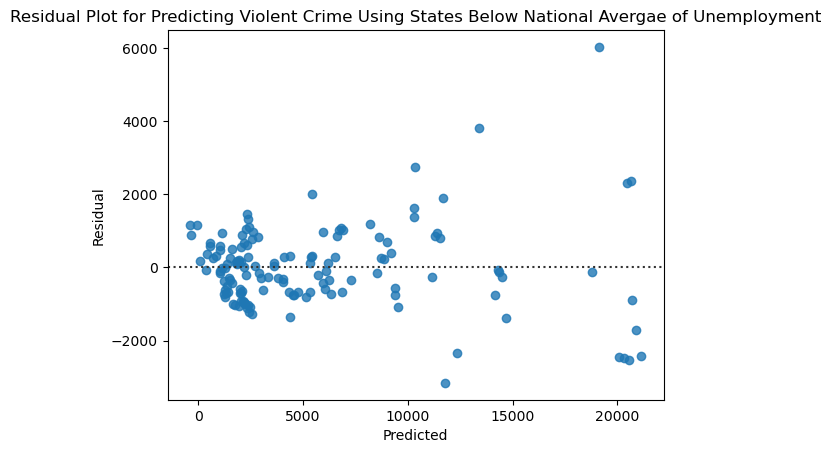

In [69]:
ax = sns.residplot(data= y_below_df, x = 'Preds', y = 'Actual')
ax.set(xlabel = "Predicted", ylabel= "Residual", title="Residual Plot for Predicting Violent Crime Using States Below National Avergae of Unemployment");

# Hypothesis 3
Income, population, unemployment and poverty can best determine the sub-category of homicide within the 4 categories of violent crime for each state regardless of year


In [70]:
crime_job = duckdb.sql('''SELECT C.State, C.Year, UnemploymentRate,
                               C.Population,
                               FROM crime_df AS C
                               JOIN job_melt AS J ON
                               C.Year = J.Year AND J.Area = C.State
                               ''').df()
cj_poverty = duckdb.sql('''SELECT C.State, C.Year, C.Population, UnemploymentRate, PovertyPercent
                               FROM crime_job AS C
                               JOIN poverty_concat AS P ON
                               C.Year = P.Year AND C.State = P.State
                               ''').df()
four_factors= duckdb.sql('''SELECT C.State, C.Year, C.Population, UnemploymentRate, PovertyPercent,
                        Median_Income
                               FROM cj_poverty AS C
                               JOIN income_melt AS I ON
                               C.Year = I.Year AND C.State = I.State
                               ORDER BY C.Year ASC''').df()
four_factors.head() #2013 - 2018

,State,Year,Population,UnemploymentRate,PovertyPercent,Median_Income
0,Alabama,2013,4833996,7.2,16.7,47320.0
1,Alaska,2013,737259,7.0,10.9,72472.0
2,Arizona,2013,6634997,7.7,20.2,52611.0
3,Arkansas,2013,2958765,7.2,17.1,39376.0
4,California,2013,38431393,8.9,14.9,60794.0


# MODEL FOR RAPE

In [71]:
rape_fourfactors= duckdb.sql('''SELECT C.Rape, F.*
                               FROM crime_df AS C
                               JOIN four_factors AS F ON
                               C.Year = F.Year AND C.State = F.State
                               ORDER BY C.Year ASC''').df()
rape_fourfactors = pd.get_dummies(rape_fourfactors, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['State'])
#print(rape_fourfactors)
X4_train_rape, X4_test_rape, Y4_train_rape, Y4_test_rape = \
  train_test_split(rape_fourfactors.iloc[:,1:], rape_fourfactors['Rape'],\
                   test_size=.30, shuffle=False)
X4_train_rape = sm.add_constant(X4_train_rape)
model_rape = sm.OLS(Y4_train_rape,X4_train_rape).fit()
#model_rape.summary()

In [72]:
#make predictions using rape model
X4_test_rape = sm.add_constant(X4_test_rape)
rape4_preds = model_rape.predict(X4_test_rape)
print( f"MAE for predicting rape using the four factors: {mean_absolute_error(Y4_test_rape, rape4_preds)}")
print( f"RSME for predicting rape using the four factors: {root_mean_squared_error(Y4_test_rape, rape4_preds)}")

MAE for predicting rape using the four factors: 311.5111383524392
RSME for predicting rape using the four factors: 513.7375186153721


## MODEL FOR HOMICIDE

In [73]:
homicide_fourfactors= duckdb.sql('''SELECT C.Homicide, F.*
                               FROM crime_df AS C
                               JOIN four_factors AS F ON
                               C.Year = F.Year AND C.State = F.State
                               ORDER BY C.Year ASC''').df()
homicide_fourfactors = pd.get_dummies(homicide_fourfactors, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['State'])
#print(homicide_fourfactors)

X4_train_homi, X4_test_homi, Y4_train_homi, Y4_test_homi = \
  train_test_split(homicide_fourfactors.iloc[:,1:], homicide_fourfactors['Homicide'],\
                   test_size=.30, shuffle=False)
X4_train_homi = sm.add_constant(X4_train_homi)
model_homicide = sm.OLS(Y4_train_homi,X4_train_homi).fit()
#model_homicide.summary()

In [74]:
#make predictions using homicide model
X4_test_homi = sm.add_constant(X4_test_homi)
homicide4_preds = model_homicide.predict(X4_test_homi)
print( f"MAE for predicting homicide using the four factors: {mean_absolute_error( Y4_test_homi,homicide4_preds)}")
print( f"RSME for predicting homicide using the four factors: {root_mean_squared_error(Y4_test_homi, homicide4_preds)}")

MAE for predicting homicide using the four factors: 56.87366280713931
RSME for predicting homicide using the four factors: 71.35952922187123


# MODEL FOR AGGRAVATED ASSAULT

In [75]:
assault_fourfactors= duckdb.sql('''SELECT C.Aggravated_Assault, F.*
                               FROM crime_df AS C
                               JOIN four_factors AS F ON
                               C.Year = F.Year AND C.State = F.State
                               ORDER BY C.Year ASC''').df()
assault_fourfactors = pd.get_dummies(assault_fourfactors, prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['State'])
#print(assault_fourfactors)

X4_train_assault, X4_test_assault, Y4_train_assault, Y4_test_assault = \
  train_test_split(assault_fourfactors.iloc[:,1:], assault_fourfactors['Aggravated_Assault'],\
                   test_size=.30, shuffle=False)
X4_train_assault = sm.add_constant(X4_train_assault)
model_assault = sm.OLS(Y4_train_assault,X4_train_assault).fit()
#model_homicide.summary()

In [76]:
#make predictions using assault model
X4_test_assault = sm.add_constant(X4_test_assault)
assault4_preds = model_assault.predict(X4_test_assault)
print( f"MAE for predicting aggravated assault using the four factors: {mean_absolute_error( Y4_test_assault,assault4_preds)}")
print( f"RSME for predicting aggravated assault using the four factors: {root_mean_squared_error(Y4_test_assault,assault4_preds)}")

MAE for predicting aggravated assault using the four factors: 1381.4995644397807
RSME for predicting aggravated assault using the four factors: 2261.3542980047837


# MODEL FOR ROBBERY

In [77]:
robbery_fourfactors= duckdb.sql('''SELECT C.Robbery, F.*
                               FROM crime_df AS C
                               JOIN four_factors AS F ON
                               C.Year = F.Year AND C.State = F.State
                               ORDER BY C.Year ASC''').df()
robbery_fourfactors = pd.get_dummies(robbery_fourfactors , prefix='', prefix_sep='',\
                                  drop_first=True, dtype=int, columns=['State'])
#print(burglary_fourfactors)

X4_train_robbery, X4_test_robbery, Y4_train_robbery, Y4_test_robbery = \
  train_test_split(robbery_fourfactors .iloc[:,1:], robbery_fourfactors ['Robbery'],\
                   test_size=.30, shuffle=False)
X4_train_robbery = sm.add_constant(X4_train_robbery)
model_robbery = sm.OLS(Y4_train_robbery,X4_train_robbery).fit()
#model_homicide.summary()

In [78]:
#make predictions using burglary model
X4_test_robbery = sm.add_constant(X4_test_robbery)
robbery4_preds = model_robbery.predict(X4_test_robbery)
print( f"MAE for predicting robbery using the four factors: {mean_absolute_error( Y4_test_robbery,robbery4_preds)}")
print( f"RSME for predicting robbery using the four factors: {root_mean_squared_error(Y4_test_robbery,robbery4_preds)}")

MAE for predicting robbery using the four factors: 922.7968416893488
RSME for predicting robbery using the four factors: 1557.5517439986706
